In [1]:
import os, sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import MaaSSim

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#!pip install MaaSSim
import MaaSSim.utils
import logging
from dotmap import DotMap
import MaaSSim.simulators
from MaaSSim.data_structures import structures as inData
from MaaSSim.day_to_day import S_driver_opt_out, S_traveller_opt_out
from MaaSSim.day_to_day import d2d_kpi_veh, d2d_kpi_pax

In [4]:
import osmnx as ox
import networkx as nx
import random
import math
import pandas as pd
import matplotlib.pyplot as plt          
import numpy as np
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

In [5]:
params = MaaSSim.utils.get_config('glance.json')
params.city = "Amsterdam, Netherlands"
params.paths.G = "../../data/graphs/Amsterdam.graphml"
params.paths.skim = "../../data/graphs/Amsterdam.csv"
params.vehicle_fixed_positions = True
params.times.patience = 600 #second
params.dist_threshold = 20000 #meter
params.dist_threshold_min = 3000 #meter

params.d2d.probabilistic = True
params.d2d.heterogeneous = False
params.d2d.B_income = 1
params.d2d.fuel_cost = 0.25 #euro/km

params.d2d.B_inveh_time = 1
params.d2d.B_exp_time = 2 #1.5 in oded's paper
params.PT_fare = 1 ## euro
params.PT_avg_speed = 6

params.nPM = 2 # number of platforms. platform id starts from 1
params.platforms.base_fare = 1.4 #euro
params.platforms.fare = float(1.20) #euro/km
params.platforms.min_fare = float(2) # euro
params.platforms.comm_rate = float(0.10)
params.platforms.discount = float(0.0)
params.platforms.daily_marketing = False

params.d2d.learning_d = 1 
params.d2d.B_Experience = 0.70
params.d2d.B_WOM = 0.20
params.d2d.B_Marketing = 0.10
params.d2d.diffusion_speed = 10/100 # speed for M is twice greater than WOM.
params.d2d.m = 5
params.d2d.mn = 100/12 # correlation = 1-(m/mn)
params.d2d.ini_att = 0.01
params.d2d.Eini_att = 0.01
params.d2d.adj_s = 2
params.VoT = 10.63 # value of time per hour
params.assert_me = False
params.seed = 1
params.paths.requests = 'Amsterdam_requests.csv'

params.nP = 2000
params.nV = 200
params.nD = 365
params.simTime = 4
params.d2d.res_wage = params.simTime*10.63 #euro

In [6]:
# params.d2d.m = params.d2d.mn means no nest no correlation between platforms. 
# As we increase params.d2d.mn, correlation increase and the same utility difference between
# platforms results in higher probability difference
# That is why when params.d2d.mn = 5, both platforms stablize on the same market share but when
# params.d2d.mn = 10 they stablize on different market shares. And PT market share is higher.

# Indeed, the smaller theta leads to deterministic model.

In [7]:
# we were expecting for a newcomer to be easier to gain market share. however, at presence of another
# platform it is even more difficult for the newcomer to launch. However, with theta m increase the
# share the w has more effect on the probability of newcomer but inside the nest becomes more 
# deterministic and newcomer gets less probability.
# Maybe we can increase the adaptation (learning) speed for the newcomer. eventhogh it wont really 
# change the gained market share

In [ ]:
sim = MaaSSim.simulators.simulate(params=params, f_driver_out=S_driver_opt_out,f_trav_out=S_traveller_opt_out,
                                  kpi_veh=d2d_kpi_veh,kpi_pax=d2d_kpi_pax, logger_level=logging.WARNING)

This simulation uses albatros data


In [45]:
sim

In [47]:
DF = pd.DataFrame()

ye1 = []; ym1 = []; yw1 = []; yms1 = []
ye2 = []; ym2 = []; yw2 = []; yms2 = []

for d in range(0,sim.params.nD):
    df = sim.res[d].pax_exp
    yw1.append(df.P1_WOM_U.mean())
    ym1.append(df.P1_MARKETING_U.mean())
    ye1.append(df.P1_EXPERIENCE_U.mean())
    yms1.append(len(df[df.platform_id==1])/params.nP)
    
    yw2.append(df.P2_WOM_U.mean())
    ym2.append(df.P2_MARKETING_U.mean())
    ye2.append(df.P2_EXPERIENCE_U.mean())
    yms2.append(len(df[df.platform_id==2])/params.nP)

DF['P_P1_WOM_U'] = yw1
DF['P_P1_MARKETING_U'] = ym1
DF['P_P1_EXPERIENCE_U'] = ye1
DF['P_P1_SHARE'] = yms1

DF['P_P2_WOM_U'] = yw2
DF['P_P2_MARKETING_U'] = ym2
DF['P_P2_EXPERIENCE_U'] = ye2
DF['P_P2_SHARE'] = yms2    



ye1 = []; ym1 = []; yw1 = []; yms1 = []
ye2 = []; ym2 = []; yw2 = []; yms2 = []

for d in range(0,sim.params.nD):
    df = sim.res[d].veh_exp
    yw1.append(df.P1_WOM_U.mean())
    ym1.append(df.P1_MARKETING_U.mean())
    ye1.append(df.P1_EXPERIENCE_U.mean())
    yms1.append(len(df[df.platform_id==1])/params.nV)
    
    yw2.append(df.P2_WOM_U.mean())
    ym2.append(df.P2_MARKETING_U.mean())
    ye2.append(df.P2_EXPERIENCE_U.mean())
    yms2.append(len(df[df.platform_id==2])/params.nV)


DF['V_P1_WOM_U'] = yw1
DF['V_P1_MARKETING_U'] = ym1
DF['V_P1_EXPERIENCE_U'] = ye1
DF['V_P1_SHARE'] = yms1

DF['V_P2_WOM_U'] = yw2
DF['V_P2_MARKETING_U'] = ym2
DF['V_P2_EXPERIENCE_U'] = ye2
DF['V_P2_SHARE'] = yms2
DF.to_csv('duo_baseline_R06_nc25_dis40.csv')

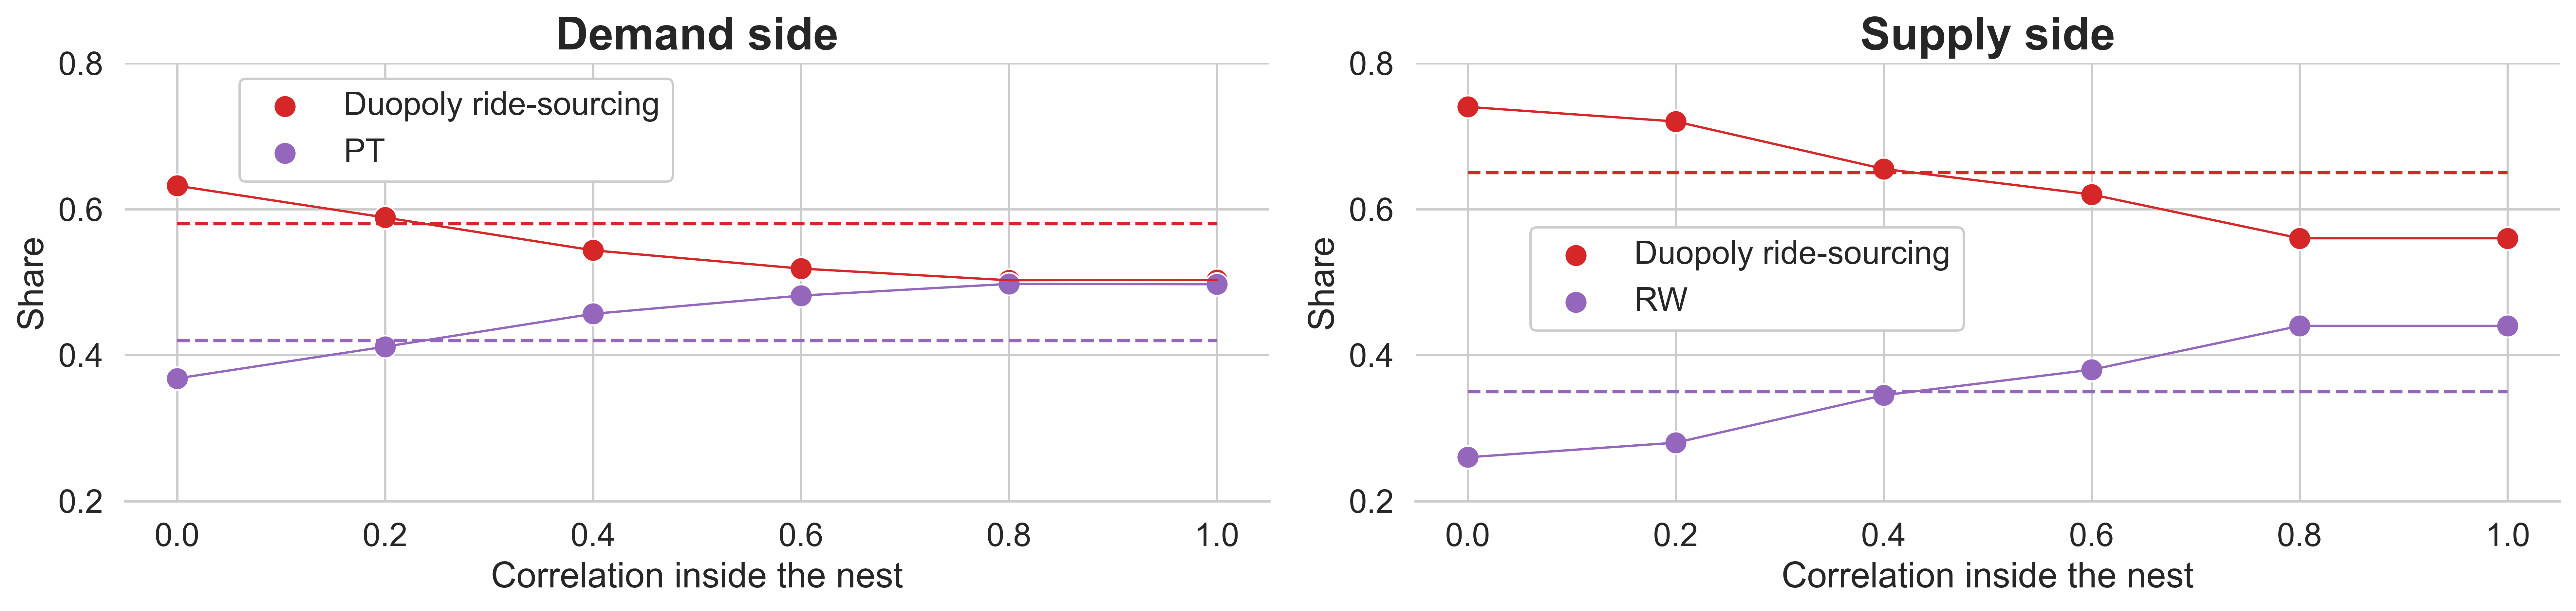

In [22]:
fd = pd.DataFrame()
fd['th_ratio'] = [0.0, 0.2, 0.4, 0.6, 0.8, 1]
# df['m_share_PT'] = []
fd['m_share_P1'] = [0.370, 0.350, 0.330, 0.280, 0.250, 0.285]
fd['m_share_P2'] = [0.370, 0.370, 0.325, 0.340, 0.310, 0.275]
fd['m_share_RH'] = fd['m_share_P1'] + fd['m_share_P2']
fd['m_share_PT'] = 1-fd['m_share_RH']

df = pd.DataFrame()
df['th_ratio'] = [0.0, 0.2, 0.4, 0.6, 0.8, 1]
# df['m_share_PT'] = []
df['m_share_P1'] = [0.3260, 0.2990, 0.2845, 0.2335, 0.1970, 0.2650]
df['m_share_P2'] = [0.3060,0.2895, 0.2590, 0.2850, 0.3055, 0.2380]
df['m_share_RH'] = df['m_share_P1'] + df['m_share_P2']
df['m_share_PT'] = 1-df['m_share_RH']

sns.set(rc={"figure.dpi":500, 'savefig.dpi':500})
sns.set(palette='tab10',font_scale=1.3)#, rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'},)
sns.set_style('whitegrid')
fig, ax = plt.subplots(ncols=2, figsize=(16,4))
sns.despine(left=True)

sns.scatterplot(x= df['th_ratio'], y=df['m_share_RH'], label= 'Duopoly ride-sourcing', s=100, color='C3', ax=ax[0])
sns.lineplot(x= df['th_ratio'], y=df['m_share_RH'], color='C3', lw=1, ax=ax[0])
sns.scatterplot(x= df['th_ratio'], y=df['m_share_PT'], label= 'PT' , s=100, color='C4', ax=ax[0])
sns.lineplot(x= df['th_ratio'], y=df['m_share_PT'], color='C4', lw=1, ax=ax[0])
ax[0].hlines([0.58], 0, 1, linestyles='dashed', color='C3')
ax[0].hlines([0.42], 0, 1, linestyles='dashed', color='C4')
ax[0].set(xlabel='Correlation inside the nest', ylabel='Share', ylim=[0.2,0.8])


sns.scatterplot(x= fd['th_ratio'], y=fd['m_share_RH'], label= 'Duopoly ride-sourcing', s=100, color='C3', ax=ax[1])
sns.lineplot(x= fd['th_ratio'], y=fd['m_share_RH'], color='C3', lw=1, ax=ax[1])
sns.scatterplot(x= fd['th_ratio'], y=fd['m_share_PT'], label= 'RW' , s=100, color='C4', ax=ax[1])
sns.lineplot(x= fd['th_ratio'], y=fd['m_share_PT'], color='C4', lw=1, ax=ax[1])
ax[1].hlines([0.65], 0, 1, linestyles='dashed', color='C3')
ax[1].hlines([0.35], 0, 1, linestyles='dashed', color='C4')
ax[1].set(xlabel='Correlation inside the nest', ylabel='Share', ylim=[0.2,0.8])


ax[0].set_title('Demand side',fontweight='bold', loc='center',fontsize=20);ax[1].set_title('Supply side',fontweight='bold', loc='center',fontsize=20)
# ax[0].grid(axis='x'); ax[1].grid(axis='y')
ax[0].legend(frameon=True,framealpha=1, loc=(0.1,0.73))
ax[1].legend(frameon=True,framealpha=1, loc=(0.1,0.39))

plt.tight_layout()
plt.savefig('Fig2.png')

In [35]:
def smooth(y,w=11,o=1,d=1):
    from scipy.signal import savgol_filter
    nans = [float('nan') for i in range(0,d)] 
    y = nans + list(savgol_filter(y[d:],w,o))
    for i in range(0,len(y)):
        if y[i]<0:
            y[i] = 0
    return y

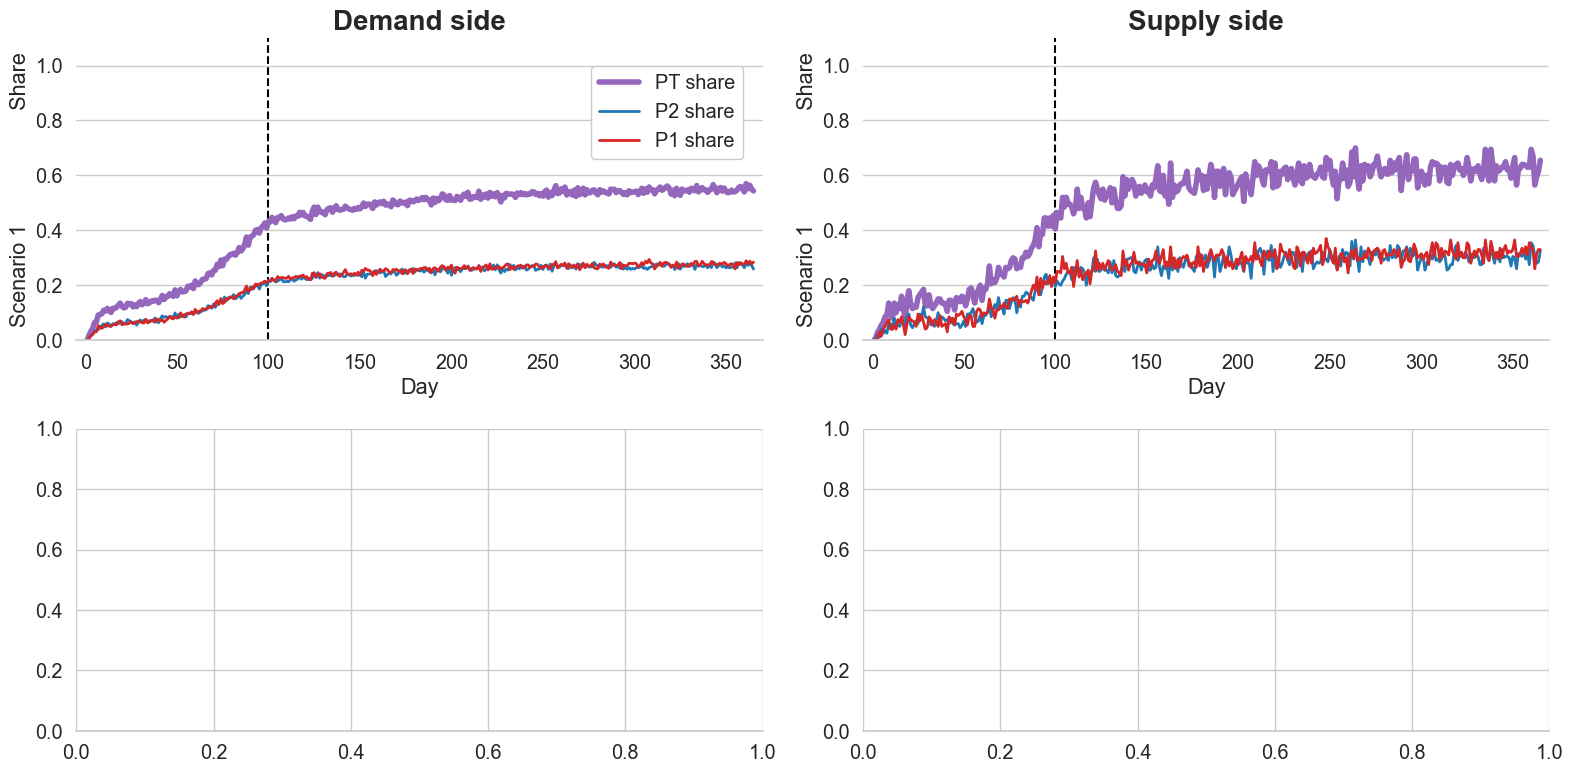

In [ ]:
sns.set(rc={"figure.dpi":100, 'savefig.dpi':100})
sns.set(palette='tab10',font_scale=1.3)#, rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'},)
sns.set_style('whitegrid')
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(16,8))
sns.despine(left=True)


df = pd.read_csv('duo_baseline_R06.csv')
yp1 = df.P_P1_SHARE
yp2 = df.P_P2_SHARE
ypt = yp1+yp2
lx = [i for i in range(1,len(ypt)+1)]
sns.lineplot(x=lx, y=ypt, label = 'PT share', color='C4', lw=4, ax=ax[0][0])#, marker='o')
sns.lineplot(x=lx, y=yp2, label = 'P2 share', color='C0', lw=2, ax=ax[0][0])#, marker='o')
sns.lineplot(x=lx, y=yp1, label = 'P1 share', color='C3', lw=2, ax=ax[0][0])#, marker='o')

yp1 = df.V_P1_SHARE
yp2 = df.V_P2_SHARE
ypt = yp1+yp2
lx = [i for i in range(1,len(ypt)+1)]
sns.lineplot(x=lx, y=ypt, label = 'RW share', color='C4', lw=4, ax=ax[0][1])#, marker='o')
sns.lineplot(x=lx, y=yp2, label = 'P2 share', color='C0', lw=2, ax=ax[0][1])#, marker='o')
sns.lineplot(x=lx, y=yp1, label = 'P1 share', color='C3', lw=2, ax=ax[0][1])#, marker='o')

for i in range(0,2):    
    ax[0][i].vlines([100], 0, 1.1, linestyles='dashed', colors='black')
    ax[0][i].grid(axis='x')
    ax[0][i].set(xlabel='Day', ylabel='Scenario 1             Share', ylim=(0,1.1),  xlim=(-5,370))
    
ax[0][0].set_title('Demand side',fontweight='bold', loc='center',fontsize=20);ax[0][1].set_title('Supply side',fontweight='bold', loc='center',fontsize=20)
ax[0][0].legend(frameon=True,framealpha=1, loc=(0.75,0.6))#,  bbox_to_anchor=(0.75, 1.24), ncol=4)
ax[0][1].get_legend().set_visible(False)

# ax[0][0].annotate('Scenario 1', xy =(-7,0.5), fontweight='bold', rotation=90)

plt.tight_layout()
# plt.savefig('Fig1.png')

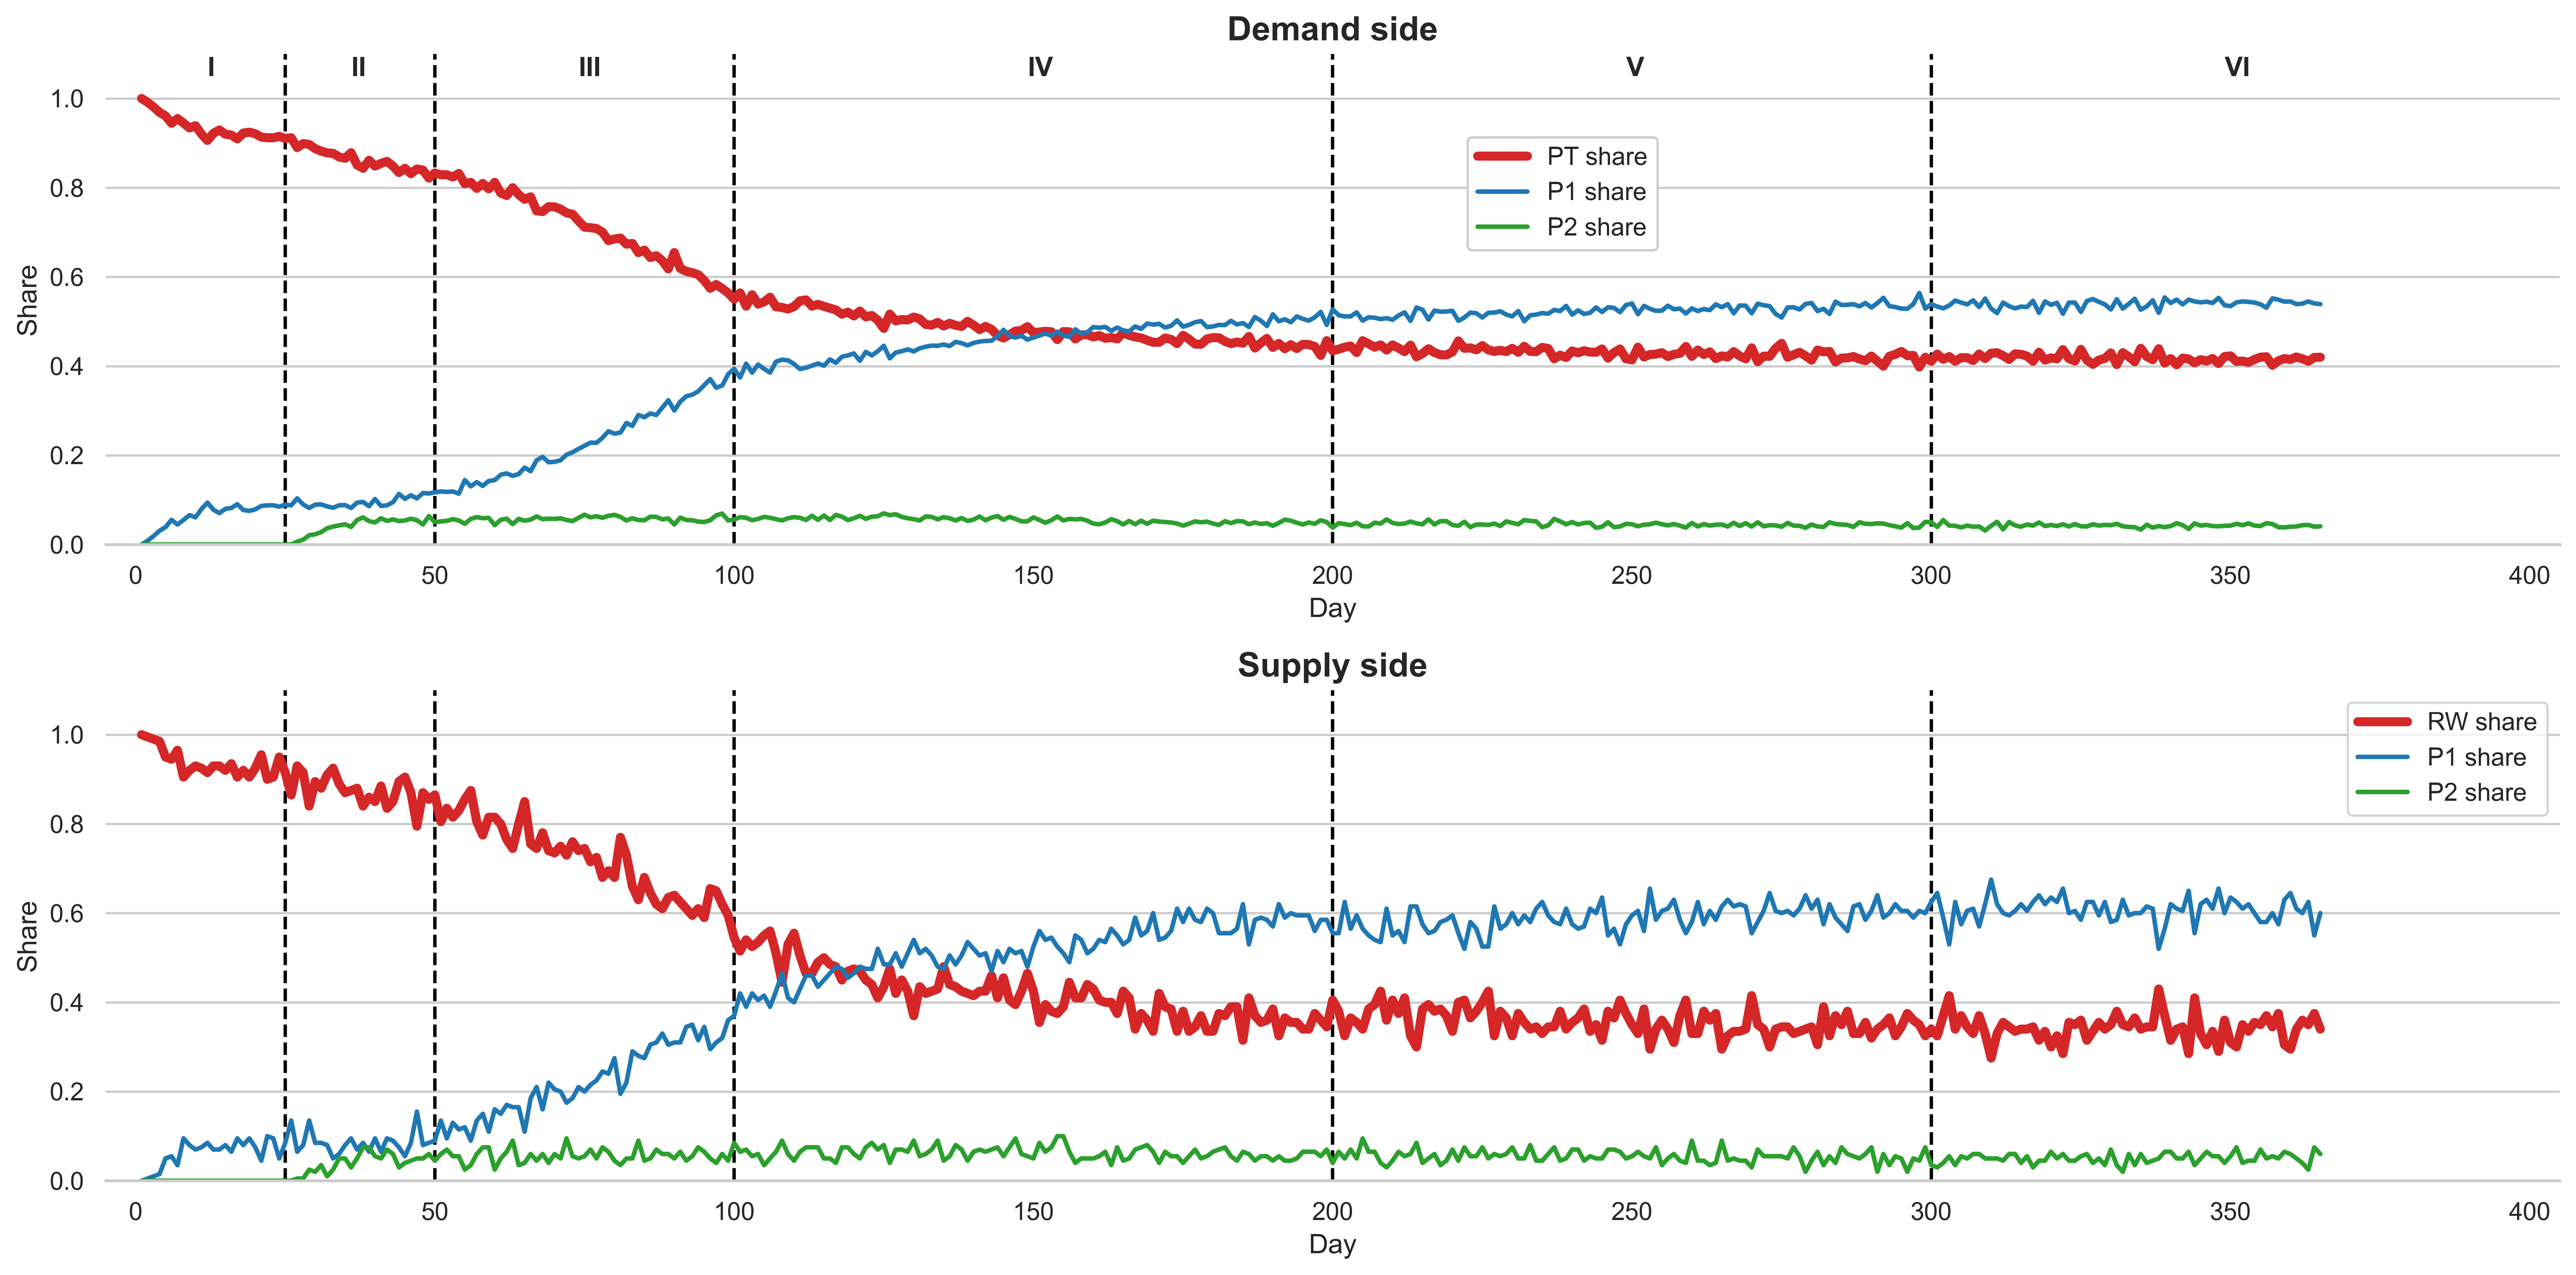

In [46]:
# with S-shaped curve nD=200 nP=2000 nV=200, with increased passenger sensitivity to changes in system
sns.set(rc={"figure.dpi":500, 'savefig.dpi':500})
sns.set(palette='tab10',font_scale=1)#, rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'},)
sns.set_style('whitegrid')
fig, ax = plt.subplots(nrows=2, figsize=(16,8))
# plt.subplots_adjust(wspace=0.3, hspace=0.4)
sns.despine(left=True)

for ax_n in [0,1]:
    
    x = []; ye = []; ym = []; yw = []; yms = []
    ypt= [] ; yp1=[]; yp2 = []
    if ax_n==0:
        for d in range(0,sim.params.nD):
            df = sim.res[d].pax_exp
            ypt.append(df.OUT.value_counts().get(True, 0)/params.nP)
            yp1.append(len(df[df.platform_id==1])/params.nP)
            yp2.append(len(df[df.platform_id==2])/params.nP)
        lx = [i for i in range(1,len(ypt)+1)]
        sns.lineplot(x=lx, y=ypt, label = 'PT share', color='C3', lw=4, ax=ax[ax_n])#, marker='o')
        sns.lineplot(x=lx, y=yp1, label = 'P1 share', color='C0', lw=2, ax=ax[ax_n])#, marker='o')
        sns.lineplot(x=lx, y=yp2, label = 'P2 share', color='C2', lw=2, ax=ax[ax_n])#, marker='o')
            
    if ax_n==1:
        for d in range(0,sim.params.nD):
            df = sim.res[d].veh_exp
            ypt.append(df.OUT.value_counts().get(True, 0)/params.nV)
            yp1.append(len(df[df.platform_id==1])/params.nV)
            yp2.append(len(df[df.platform_id==2])/params.nV)
        lx = [i for i in range(1,len(ypt)+1)]
        sns.lineplot(x=lx, y=ypt, label = 'RW share', color='C3', lw=4, ax=ax[ax_n])#, marker='o')
        sns.lineplot(x=lx, y=yp1, label = 'P1 share', color='C0', lw=2, ax=ax[ax_n])#, marker='o')
        sns.lineplot(x=lx, y=yp2, label = 'P2 share', color='C2', lw=2, ax=ax[ax_n])#, marker='o')

    
   
    ax[ax_n].vlines([25, 50, 100, 200, 300], 0, 1.1, linestyles='dashed', colors='black')
    ax[ax_n].grid(axis='x')
    ax[ax_n].set(xlabel='Day', ylabel='Share', ylim=(0,1.1),  xlim=(-5,405))
    
ax[0].set_title('Demand side',fontweight='bold', loc='center',fontsize=15);ax[1].set_title('Supply side',fontweight='bold', loc='center',fontsize=15)
ax[0].legend(frameon=True,framealpha=1, loc=(0.555,0.6))#,  bbox_to_anchor=(0.75, 1.24), ncol=4)
# ax[1].get_legend().set_visible(False)
for i in range(0,6):
    value = ['I','II','III','IV','V','VI']
    coords = [(12,1.05),(36,1.05),(74,1.05),(149,1.05),(249,1.05),(349,1.05)]
    ax[0].annotate(value[i], xy =coords[i], fontweight='bold')

# plt.yticks([0,1])

plt.tight_layout()
# plt.savefig('Fig1.png')

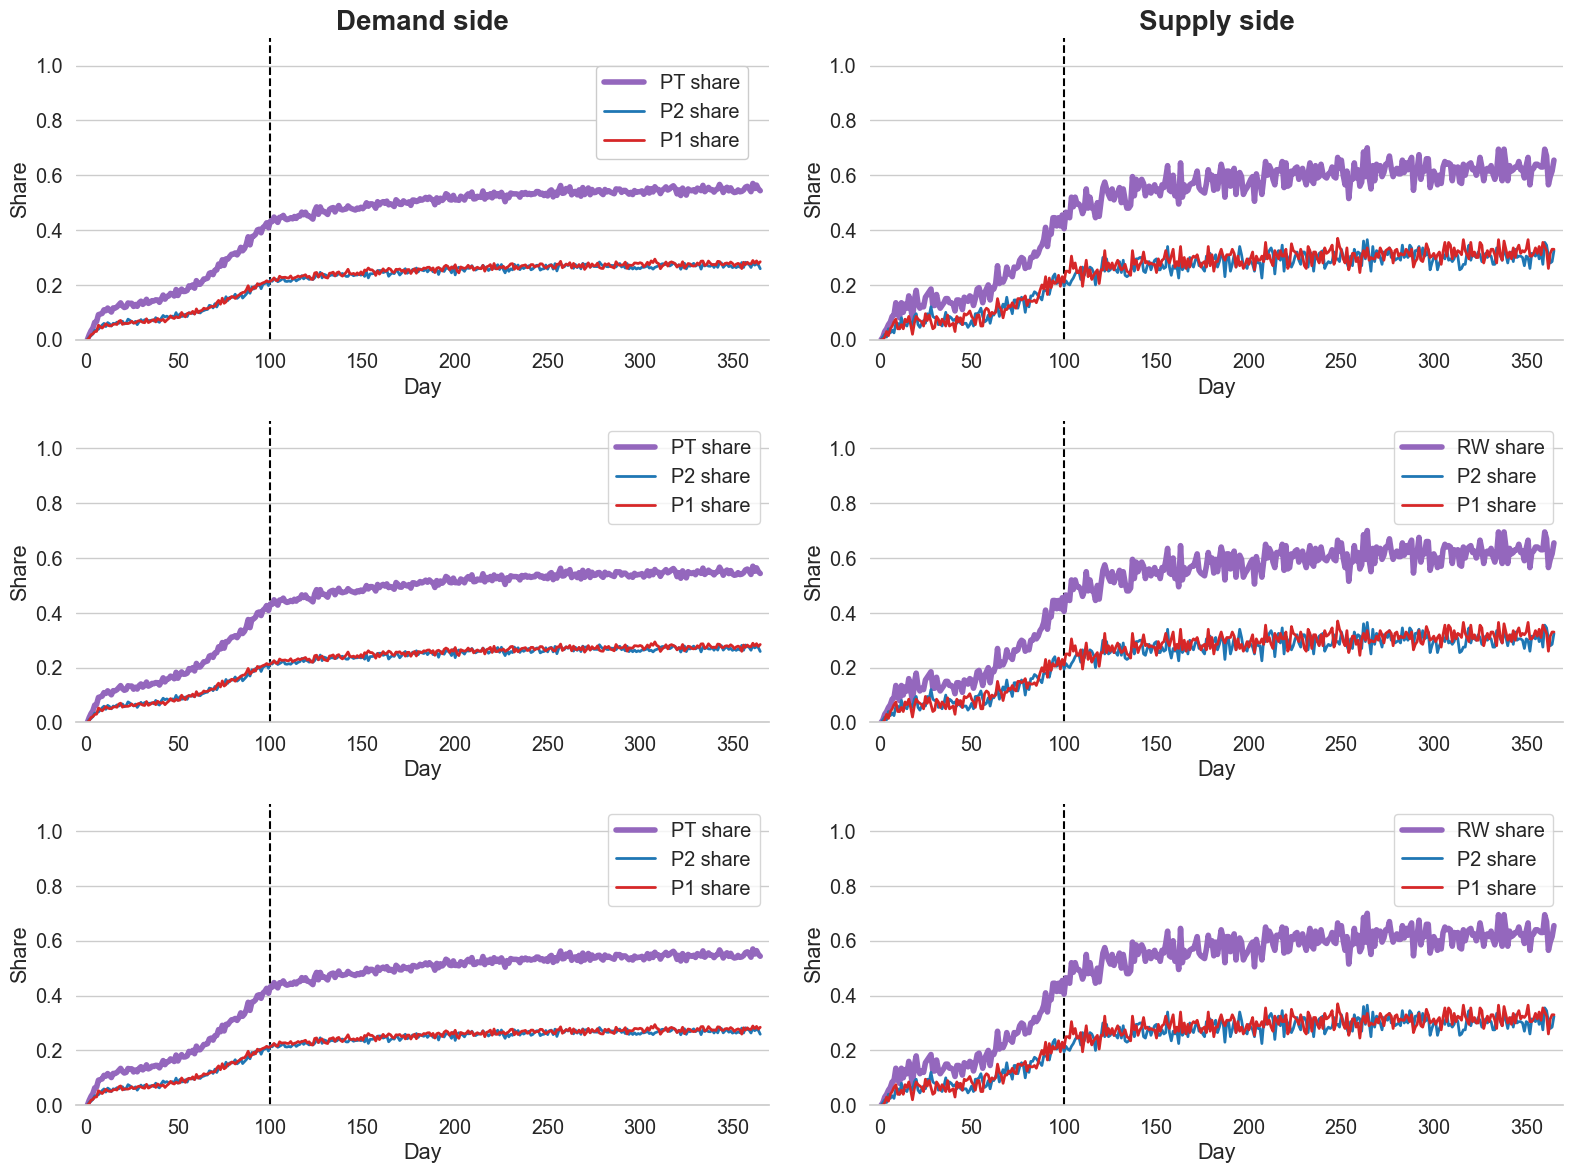

In [27]:
sns.set(rc={"figure.dpi":100, 'savefig.dpi':100})
sns.set(palette='tab10',font_scale=1.3)#, rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'},)
sns.set_style('whitegrid')
fig, ax = plt.subplots(nrows=3,ncols=2, figsize=(16,12))
sns.despine(left=True)

paths = ['duo_baseline_R06.csv', 'duo_baseline_R06.csv', 'duo_baseline_R06.csv'] 

for i in range(0,3):
    
    df = pd.read_csv(paths[i])
    yp1 = df.P_P1_SHARE
    yp2 = df.P_P2_SHARE
    ypt = yp1+yp2
    lx = [i for i in range(1,len(ypt)+1)]
    sns.lineplot(x=lx, y=ypt, label = 'PT share', color='C4', lw=4, ax=ax[i][0])#, marker='o')
    sns.lineplot(x=lx, y=yp2, label = 'P2 share', color='C0', lw=2, ax=ax[i][0])#, marker='o')
    sns.lineplot(x=lx, y=yp1, label = 'P1 share', color='C3', lw=2, ax=ax[i][0])#, marker='o')

    yp1 = df.V_P1_SHARE
    yp2 = df.V_P2_SHARE
    ypt = yp1+yp2
    lx = [i for i in range(1,len(ypt)+1)]
    sns.lineplot(x=lx, y=ypt, label = 'RW share', color='C4', lw=4, ax=ax[i][1])#, marker='o')
    sns.lineplot(x=lx, y=yp2, label = 'P2 share', color='C0', lw=2, ax=ax[i][1])#, marker='o')
    sns.lineplot(x=lx, y=yp1, label = 'P1 share', color='C3', lw=2, ax=ax[i][1])#, marker='o')

    for j in range(0,2):    
        ax[i][j].vlines([100], 0, 1.1, linestyles='dashed', colors='black')
        ax[i][j].grid(axis='x')
        ax[i][j].set(xlabel='Day', ylabel='Share', ylim=(0,1.1),  xlim=(-5,370))

    

ax[0][0].set_title('Demand side',fontweight='bold', loc='center',fontsize=20);ax[0][1].set_title('Supply side',fontweight='bold', loc='center',fontsize=20)
ax[0][0].legend(frameon=True,framealpha=1, loc=(0.75,0.6))#,  bbox_to_anchor=(0.75, 1.24), ncol=4)
ax[0][1].get_legend().set_visible(False)

# ax[0][0].annotate('Scenario 1', xy =(-7,0.5), fontweight='bold', rotation=90)

plt.tight_layout()
# plt.savefig('Fig1.png')

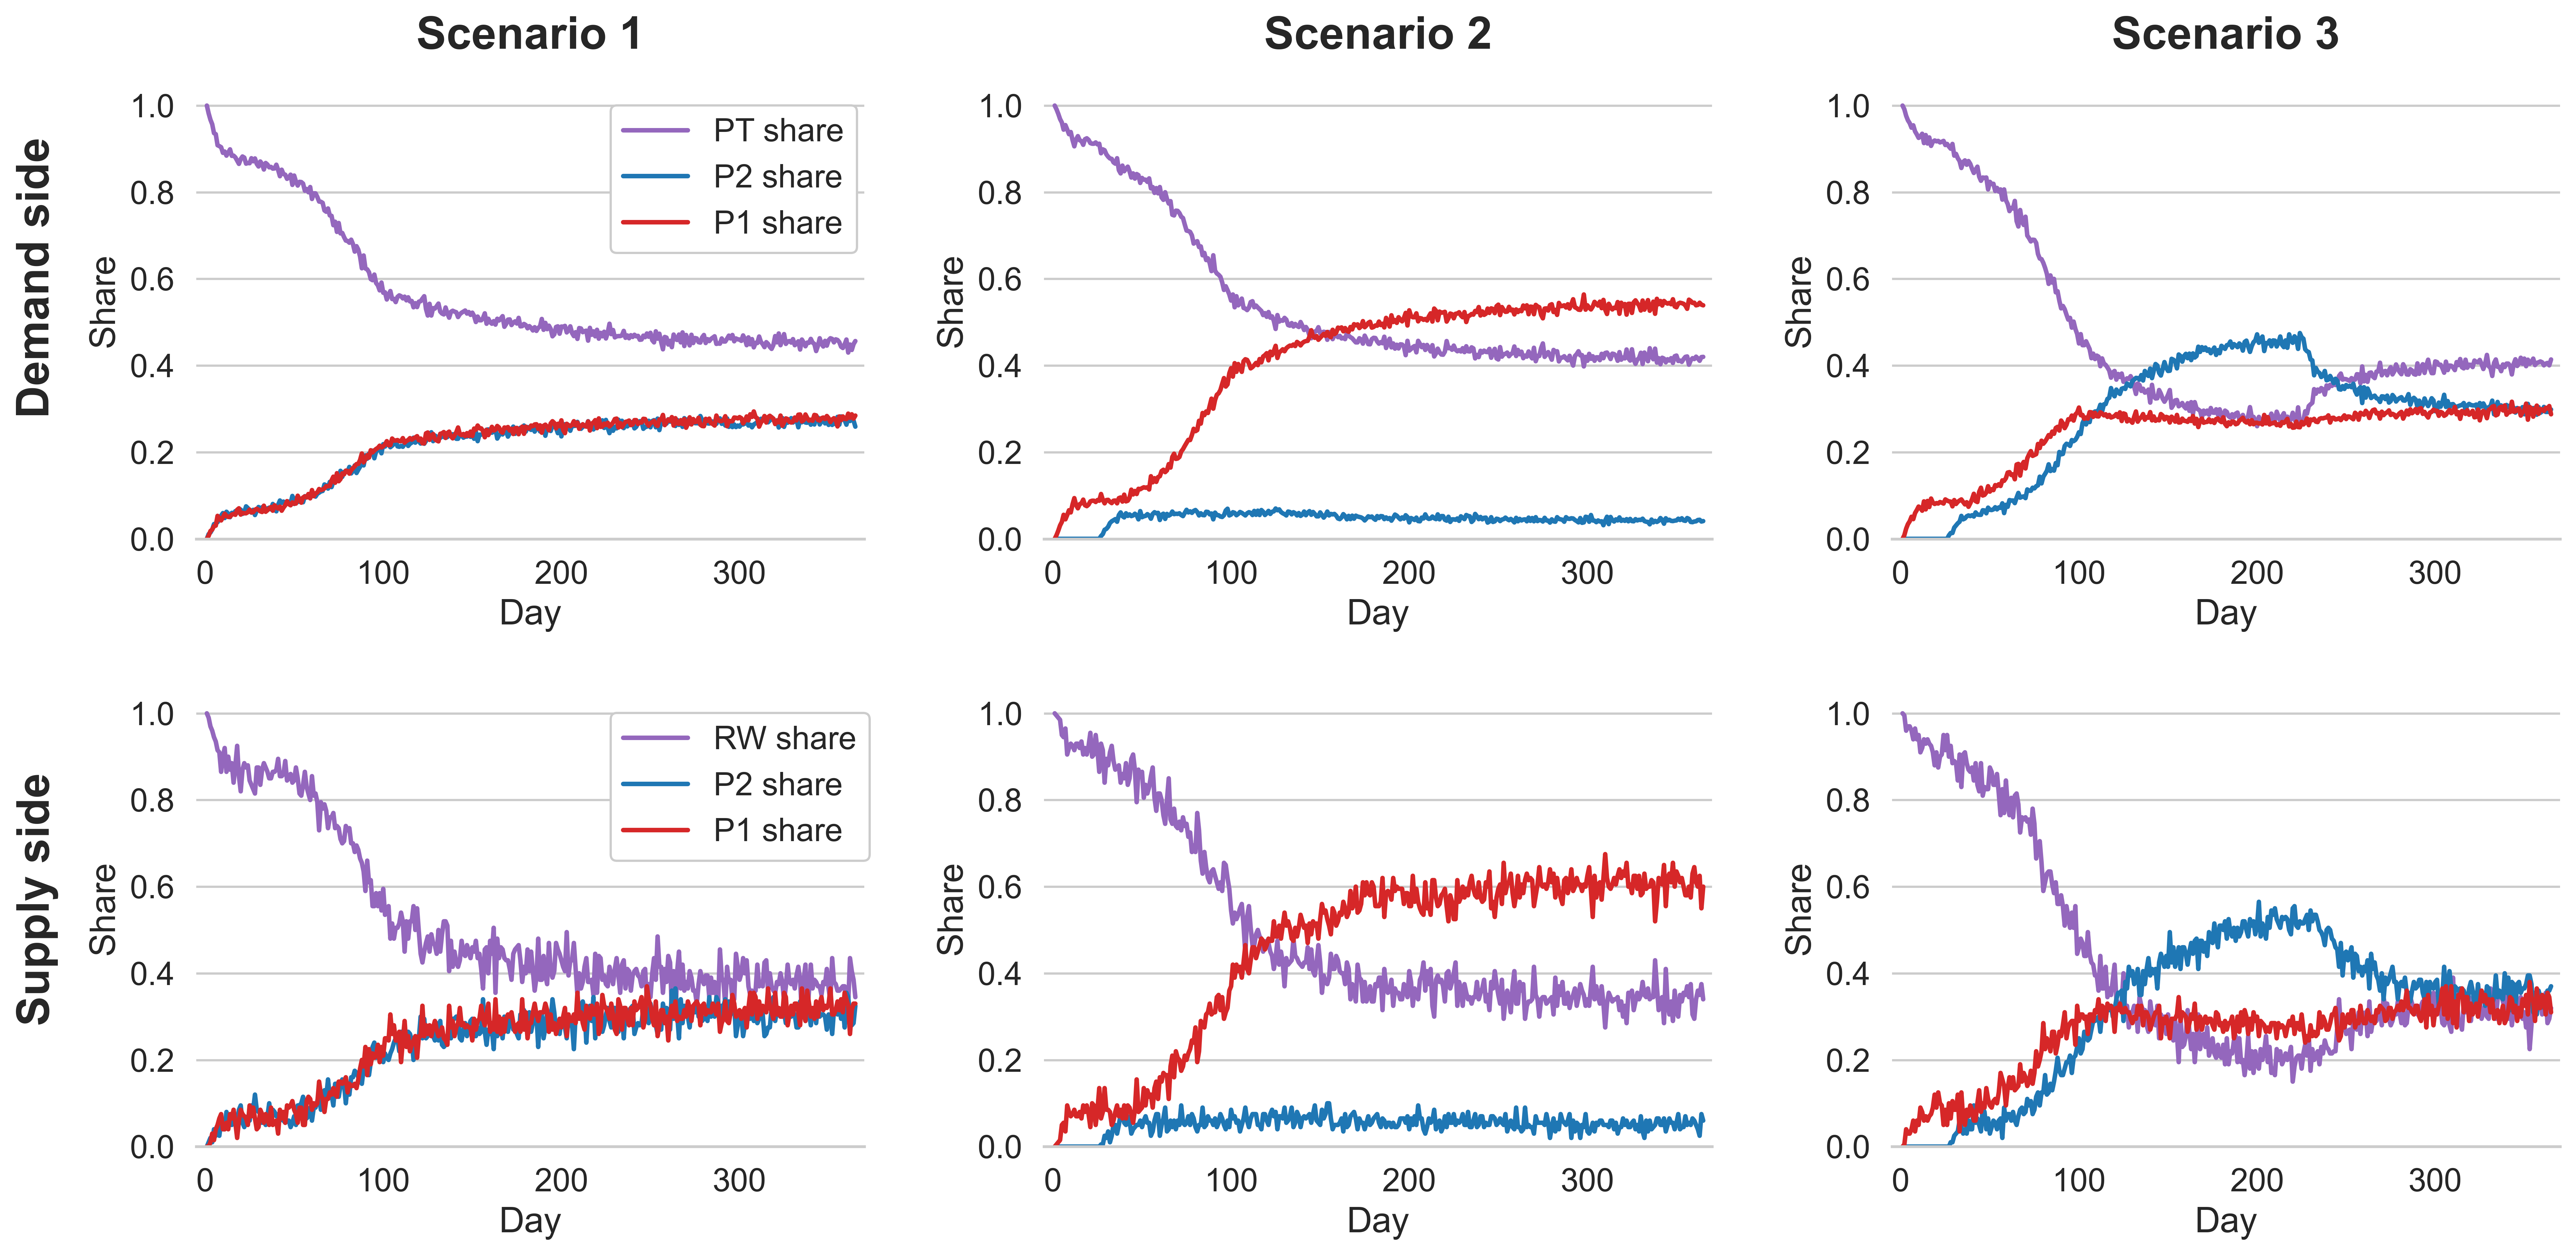

In [29]:
sns.set(rc={"figure.dpi":500, 'savefig.dpi':500})
sns.set(palette='tab10',font_scale=1.3)#, rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'},)
sns.set_style('whitegrid')
fig, ax = plt.subplots(nrows=2,ncols=3, figsize=(16,8))
sns.despine(left=True)

paths = ['duo_baseline_R06.csv', 'duo_baseline_R06_nc25_dis40.csv', 'duo_baseline_R06_nc25_dis80.csv'] 

for i in range(0,3):
    
    df = pd.read_csv(paths[i])
    yp1 = df.P_P1_SHARE; yp2 = df.P_P2_SHARE; ypt = 1-(yp1+yp2)
    lx = [i for i in range(1,len(ypt)+1)]
    
    sns.lineplot(x=lx, y=ypt, label = 'PT share', color='C4', lw=2, ax=ax[0][i])#, marker='o')
    sns.lineplot(x=lx, y=yp2, label = 'P2 share', color='C0', lw=2, ax=ax[0][i])#, marker='o')
    sns.lineplot(x=lx, y=yp1, label = 'P1 share', color='C3', lw=2, ax=ax[0][i])#, marker='o')

    yp1 = df.V_P1_SHARE; yp2 = df.V_P2_SHARE; ypt = 1-(yp1+yp2)# smooth(yp1+yp2, w=5,o=3,d=1)
    lx = [i for i in range(1,len(ypt)+1)]
    
    sns.lineplot(x=lx, y=ypt, label = 'RW share', color='C4', lw=2, ax=ax[1][i])#, marker='o')
    sns.lineplot(x=lx, y=yp2, label = 'P2 share', color='C0', lw=2, ax=ax[1][i])#, marker='o')
    sns.lineplot(x=lx, y=yp1, label = 'P1 share', color='C3', lw=2, ax=ax[1][i])#, marker='o')

    for j in range(0,2):    
        # ax[j][i].vlines([100], 0, 1.1, linestyles='dashed', colors='black')
        ax[j][i].grid(axis='x')
        ax[j][i].set(xlabel='Day', ylabel='Share', ylim=(0,1.1),  xlim=(-5,370))
        ax[j][i].get_legend().set_visible(False)
    ax[0][i].set_title('Scenario {}'.format(i+1),fontweight='bold', loc='center',fontsize=20)

ax[0][0].get_legend().set_visible(True)
ax[0][0].legend(frameon=True,framealpha=1, loc=(0.62,0.6))
ax[1][0].get_legend().set_visible(True)
ax[1][0].legend(frameon=True,framealpha=1, loc=(0.62,0.6))

ax[0][0].text(x=-106 ,y=0.3, s='Demand side',fontweight='bold',fontsize=20, rotation=90)
ax[1][0].text(x=-106 ,y=0.3, s='Supply side',fontweight='bold',fontsize=20, rotation=90)

plt.tight_layout()
plt.savefig('Fig3.png')

In [ ]:
=======================================================================================================================================================================

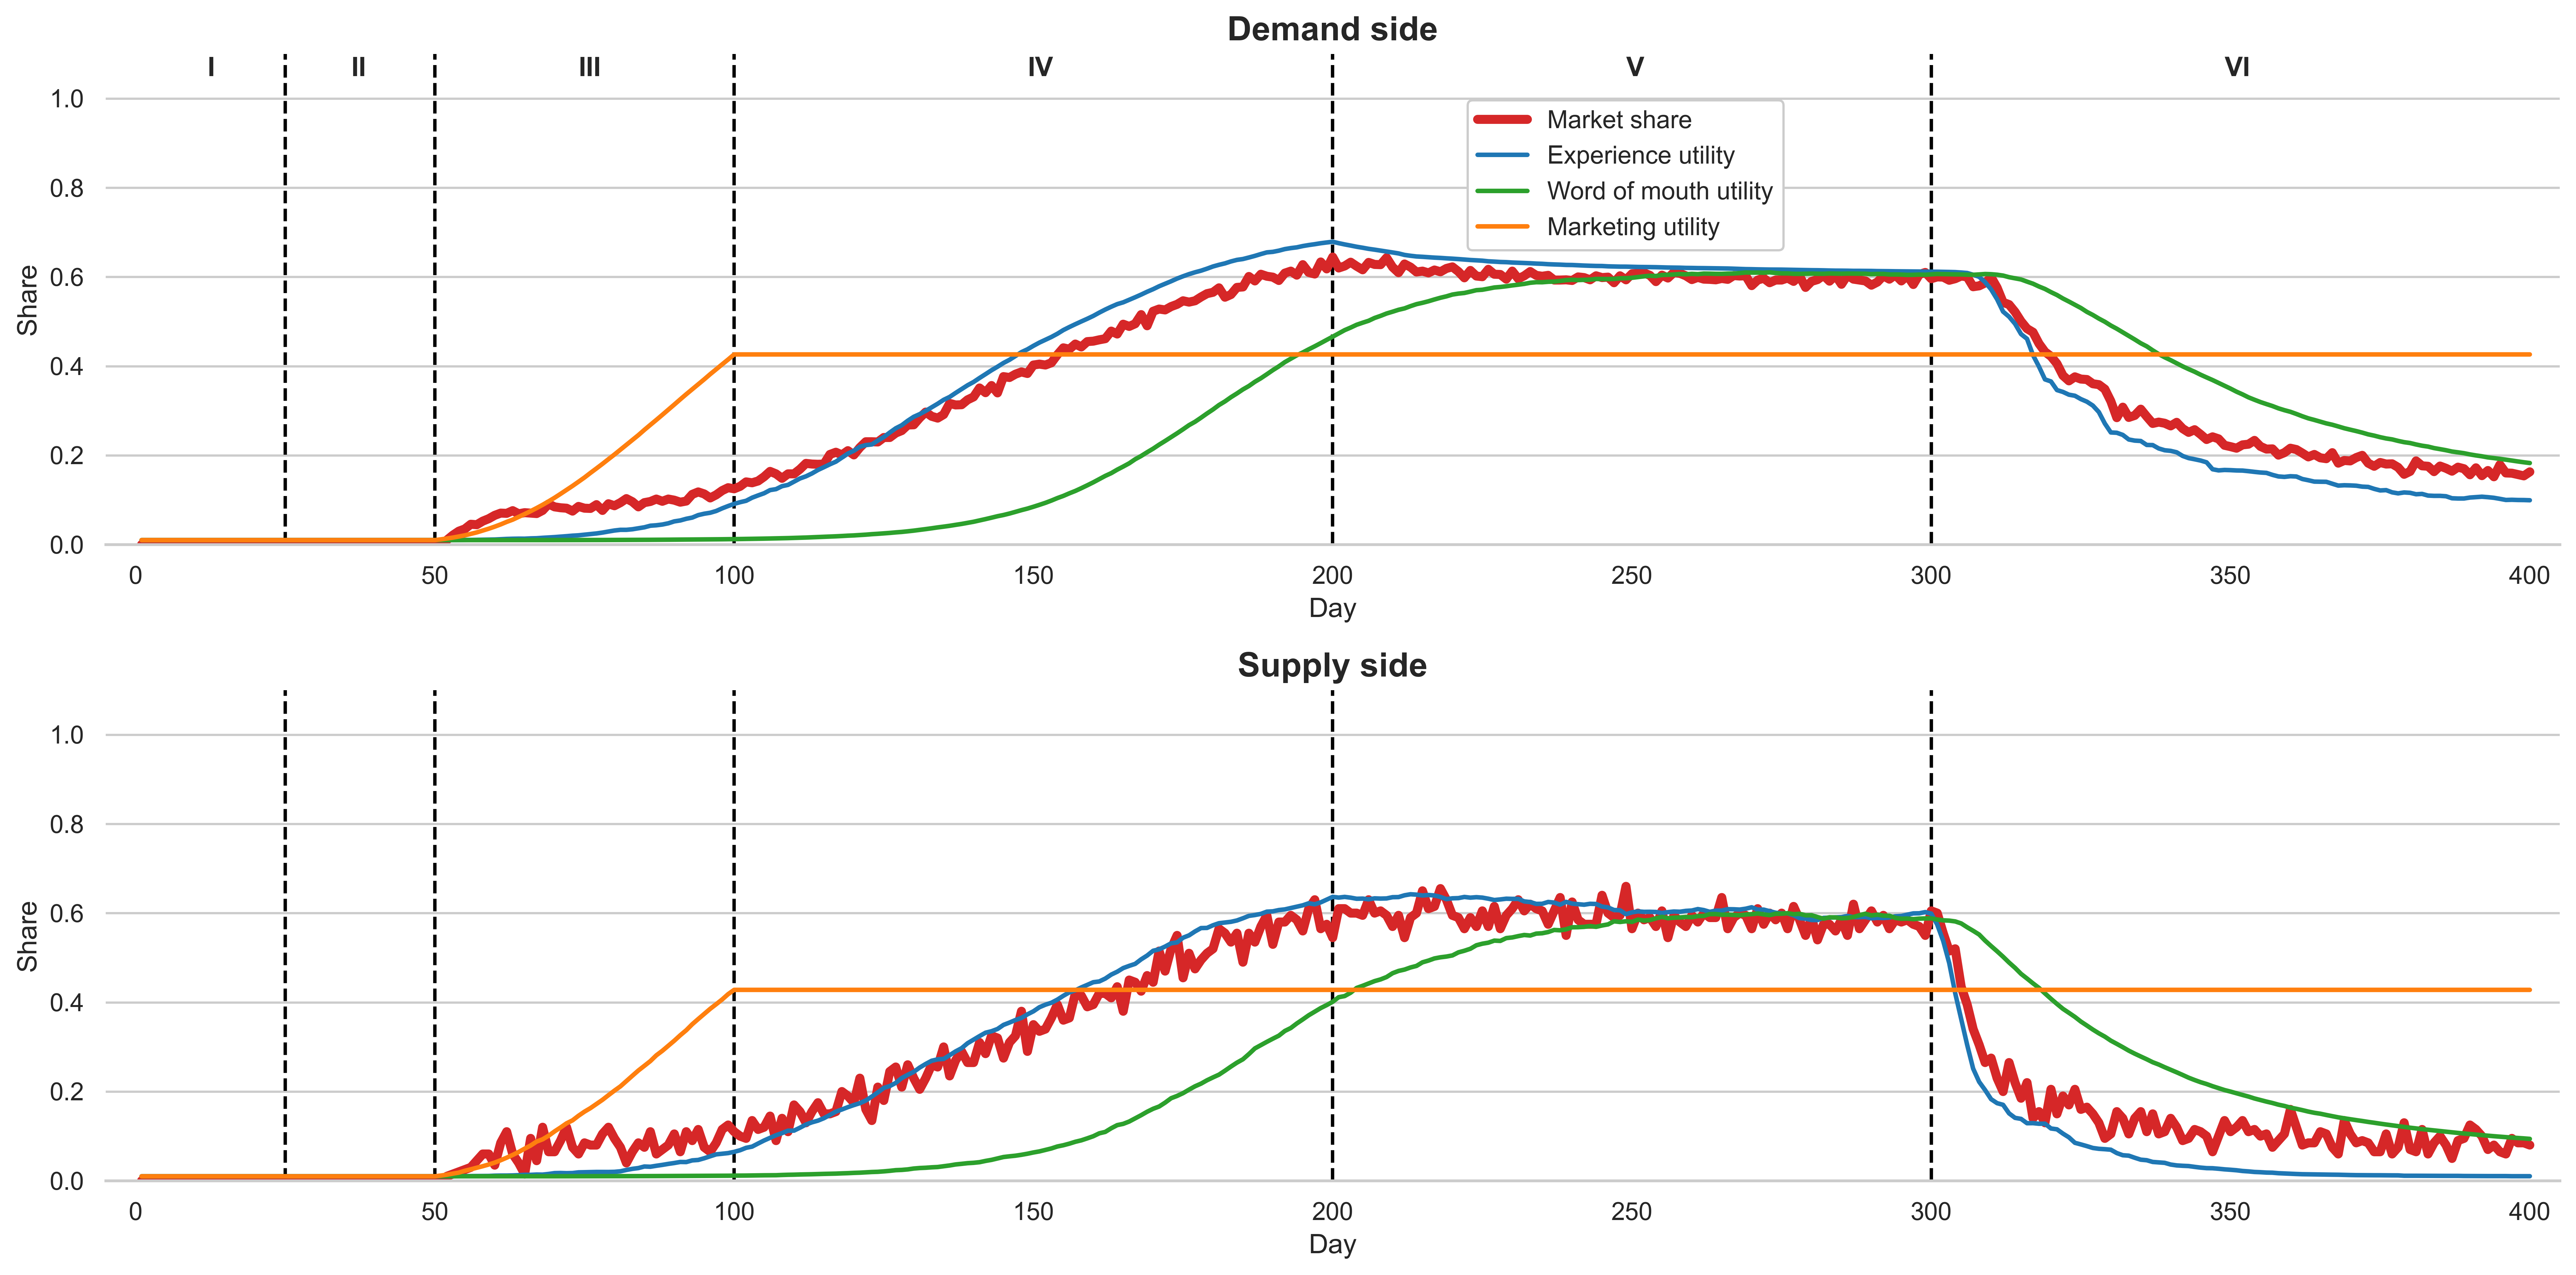

In [ ]:
# baseline model for day to day evolution of single platform

sns.set(rc={"figure.dpi":500, 'savefig.dpi':500})
sns.set(palette='tab10',font_scale=1)#, rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'},)
sns.set_style('whitegrid')
fig, ax = plt.subplots(nrows=2, figsize=(16,8))
# plt.subplots_adjust(wspace=0.3, hspace=0.4)
sns.despine(left=True)

for ax_n in [0,1]:
    
    x = []; ye = []; ym = []; yw = []; yms = []
    if ax_n==0:
        for d in range(0,sim.params.nD):
            yw.append(sim.res[d].pax_exp.WOM_U.mean())
            ym.append(sim.res[d].pax_exp.MARKETING_U.mean())
            ye.append(sim.res[d].pax_exp.EXPERIENCE_U.mean())
            yms.append(sim.res[d].pax_exp.OUT.value_counts().get(False, 0)/params.nP)
            
    if ax_n==1:
        for d in range(0,sim.params.nD):
            yw.append(sim.res[d].veh_exp.WOM_U.mean())
            ym.append(sim.res[d].veh_exp.MARKETING_U.mean())
            ye.append(sim.res[d].veh_exp.EXPERIENCE_U.mean())
            yms.append(sim.res[d].veh_exp.OUT.value_counts().get(False, 0)/params.nV)
    
    lx = [i for i in range(1,len(ye)+1)]
    sns.lineplot(x=lx, y=yms, label = 'Market share', color='C3', lw=4, ax=ax[ax_n])#, marker='o')
    sns.lineplot(x=lx, y=ye, label = 'Experience utility', color='C0', lw=2, ax=ax[ax_n])#, marker='o')
    sns.lineplot(x=lx, y=yw, label = 'Word of mouth utility', color='C2', lw=2, ax=ax[ax_n])#, marker='o')
    sns.lineplot(x=lx, y=ym, label = 'Marketing utility', color='C1', lw=2, ax=ax[ax_n])#, marker='o')
   
    ax[ax_n].vlines([25, 50, 100, 200, 300], 0, 1.1, linestyles='dashed', colors='black')
    ax[ax_n].grid(axis='x')
    ax[ax_n].set(xlabel='Day', ylabel='Share', ylim=(0,1.1),  xlim=(-5,405))
    
ax[0].set_title('Demand side',fontweight='bold', loc='center',fontsize=15);ax[1].set_title('Supply side',fontweight='bold', loc='center',fontsize=15)
ax[0].legend(frameon=True,framealpha=1, loc=(0.555,0.6))#,  bbox_to_anchor=(0.75, 1.24), ncol=4)
ax[1].get_legend().set_visible(False)
for i in range(0,6):
    value = ['I','II','III','IV','V','VI']
    coords = [(12,1.05),(36,1.05),(74,1.05),(149,1.05),(249,1.05),(349,1.05)]
    ax[0].annotate(value[i], xy =coords[i], fontweight='bold')

# plt.yticks([0,1])

plt.tight_layout()
# plt.savefig('Fig1.png')

In [ ]:
x=1
sim.res[1].pax_exp['P{}_WOM_U'.format(x)].mean()
sim.res[1].pax_exp['P{}_WOM_U'.format(x)].mean()

0.010000000000000163

In [22]:
def smooth(y,w=11,o=1,d=51):
    from scipy.signal import savgol_filter
    nans = [float('nan') for i in range(0,51)] 
    y = nans + list(savgol_filter(y[d:],w,o))
    for i in range(0,len(y)):
        if y[i]<0:
            y[i] = 0
    return y

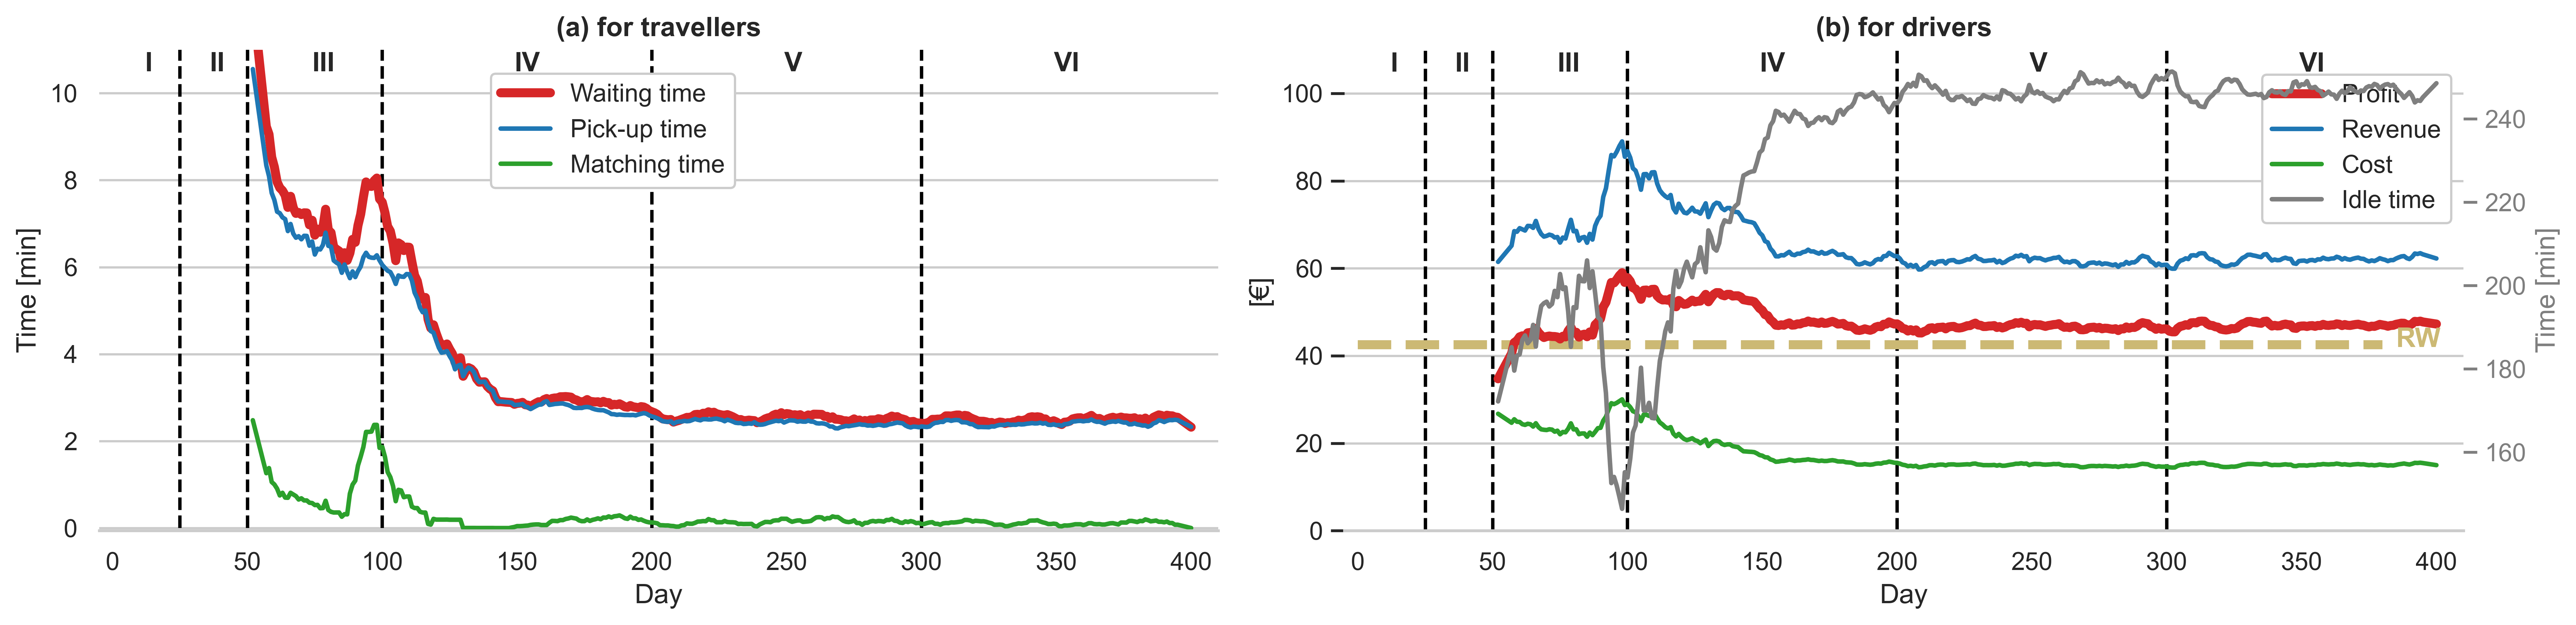

In [23]:
sns.set(rc={"figure.dpi":500, 'savefig.dpi':500})
sns.set(palette='tab10',font_scale=1)#, rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'},)
sns.set_style('whitegrid')

fig, ax = plt.subplots(ncols=2, figsize=(16,4))
sns.despine(left=True)
    

x = []
yw = []
yp = []
yi = []
ym = []
yr = []
yprof = []
yc = []

for d in range(0,sim.params.nD):
    df = sim.res[d].pax_exp
    yw.append(df[df.OUT==False].ACTUAL_WT.mean()) # Waiting time per passenger
    ym.append(df[df.OUT==False].MATCHING_T.mean()) # Matching time per passenger
    # yprof.append(df.plat_profit.sum())
    
    df = sim.res[d].veh_exp
    yp.append(df[df.OUT==False].ARRIVES_AT_PICKUP.mean()/(df[df.OUT==False].nRIDES.mean()*60))
    yi.append(df[df.OUT==False].IDLE_TIME.mean()/60)
    yr.append(df[df.OUT==False].REVENUE.mean())
    yprof.append(df[df.OUT==False].ACTUAL_INC.mean())
    yc.append(df[df.OUT==False].COST.mean())



yw = smooth(yw)
ym = smooth(ym)
yp = smooth(yp)
yi = smooth(yi)
yr = smooth(yr)
yprof = smooth(yprof)
yc = smooth(yc)

x = [i for i in range(1,len(yp)+1)]
sns.lineplot(x=x, y=yw, label = 'Waiting time', color='C3',lw=4, ax=ax[0])#, marker='o')
sns.lineplot(x=x, y=yp, label = 'Pick-up time', color='C0',lw=2, ax=ax[0])#, marker='o')
sns.lineplot(x=x, y=ym, label = 'Matching time', color='C2',lw=2, ax=ax[0])#, marker='o')
sns.lineplot(x=x, y=yprof, label = 'Profit', color='C3',lw=4, ax=ax[1])#, marker='o')
sns.lineplot(x=x, y=yr, label = 'Revenue', color='C0',lw=2, ax=ax[1])#, marker='o')
sns.lineplot(x=x, y=yc, label = 'Cost', color='C2',lw=2, ax=ax[1])#, marker='o')ax.twinx()
ax11 = ax[1].twinx()
sns.lineplot(x=x, y=yi, label = 'Idle time', color='C7',lw=2, ax=ax11)#, marker='o')
ax11.set(ylabel='Time [min]')
ax11.grid(b=None)

lines, labels = ax[1].get_legend_handles_labels()
lines2, labels2 = ax11.get_legend_handles_labels()
ax[1].legend(lines + lines2, labels + labels2,framealpha=1, loc=(0.82,0.64))
ax11.legend().remove()
# ax11.spines['right'].set_color('C7')
ax11.tick_params(axis='y', colors='C7')
ax11.yaxis.label.set_color('C7')

for i in [0,1]:
    ax[i].grid(axis='x')

ax[0].vlines([25, 50, 100, 200, 300], 0, 11, linestyles='dashed', colors='black')
ax[1].vlines([25, 50, 100, 200, 300], 0, 110, linestyles='dashed', colors='black')
ax[1].hlines([params.d2d.res_wage], 0, 380, linestyles='dashed', colors='y', lw=4)
ax[1].annotate('RW', xy =(385,42), fontweight='bold', color='y')

value = ['I','II','III','IV','V','VI']
for i in range(0,6):
    coords = [(12,10.5),(36,10.5),(74,10.5),(149,10.5),(249,10.5),(349,10.5)]
    ax[0].annotate(value[i], xy =coords[i], fontweight='bold')
for i in range(0,6):
    coords = [(12,105),(36,105),(74,105),(149,105),(249,105),(349,105)]
    ax[1].annotate(value[i], xy =coords[i], fontweight='bold')    
    
ax[0].set(xlabel='Day', ylabel='Time [min]', ylim=(-0.06,11), xlim=(-5,410)); ax[1].set(xlabel='Day', ylabel='[€]', ylim=(0,110),xlim=(-5,410))
ax[0].legend(loc=(0.35,0.713),framealpha=1)
sns.despine(left=True)

ax[0].set_title('(a) for travellers',fontweight='bold')
ax[1].set_title('(b) for drivers',fontweight='bold')

plt.tight_layout()
# plt.savefig('Fig3.png')

In [14]:
from numpy import log as ln

params.d2d.mn = 10
params.d2d.m = 5

alts_u = {'RW': 0.5, 'plats':{'P1': 'Nan', 'P2': 'Nan'}}
alts_x = {'RW': 'Nan', 'P1': 'Nan', 'P2': 'Nan', 'plats':{'P1': 'Nan', 'P2': 'Nan'}}
alts_p = {'RW': 'Nan', 'plats':{'P1': 'Nan', 'P2': 'Nan'}}

alts_u = {'RW': 0.5, 'plats':{'P1': 0.5, 'P2': 0.45}}

for p in alts_u['plats']: # calculate X in platform nest
    alts_x['plats'][p] = math.exp(params.d2d.mn*alts_u['plats'][p]) if alts_u['plats'][p]!= 'Nan' else 0

print('alts_x   ', alts_x)
w = (1/params.d2d.mn)*ln(sum(alts_x['plats'].values()))    # RH satisfaction - Logsum
print(w)
for p in alts_u['plats']: # calculate probability in platform nest
    alts_p['plats'][p] = alts_x['plats'][p]/sum(alts_x['plats'].values())
    alts_u[p] = w if alts_u['plats'][p]!= 'Nan' else 'Nan'
    
alts_x.pop('plats', None)
for alt in alts_x:
    alts_x[alt] = math.exp(params.d2d.m*alts_u[alt]) if alts_u[alt]!= 'Nan' else 0

x_w = math.exp(params.d2d.m*w)
for alt in alts_x:
    alts_p[alt] = (alts_x[alt]/(alts_x['RW'] + x_w))*alts_p['plats'][alt] if alt!='RW' else alts_x[alt]/(alts_x['RW'] + x_w)

print(alts_u)
alts_p

alts_x    {'RW': 'Nan', 'P1': 'Nan', 'P2': 'Nan', 'plats': {'P1': 148.4131591025766, 'P2': 90.01713130052181}}
0.5474076984180106
{'RW': 0.5, 'plats': {'P1': 0.5, 'P2': 0.45}, 'P1': 0.5474076984180106, 'P2': 0.5474076984180106}


{'RW': 0.4410162963544466,
 'plats': {'P1': 0.6224593312018546, 'P2': 0.3775406687981454},
 'P1': 0.34794462232394685,
 'P2': 0.21103908132160654}